In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import copy
import matplotlib.pyplot as plt

Read Data

In [59]:
fullWRData = pd.read_csv('Data/WRDataSet.csv', usecols=['EarlyDeclare', 'FanScore', 'draft_team', 'draft_ovr', 'school', 'ht', 'wt', 'forty', 'vertical', 'NFLFanScore'])
X = fullWRData.drop(columns='NFLFanScore')
y = fullWRData['NFLFanScore']

Encode categorical variables

In [60]:
enc = LabelEncoder()
X["EarlyDeclare"] = enc.fit_transform(X["EarlyDeclare"])
X = pd.get_dummies(X, columns=['school', 'draft_team'])
X.head()

,EarlyDeclare,FanScore,draft_ovr,ht,wt,forty,vertical,school_Ala-Birmingham,school_Alabama,school_Arizona,...,draft_team_Pittsburgh Steelers,draft_team_San Diego Chargers,draft_team_San Francisco 49ers,draft_team_Seattle Seahawks,draft_team_St. Louis Rams,draft_team_Tampa Bay Buccaneers,draft_team_Tennessee Titans,draft_team_Washington Commanders,draft_team_Washington Football Team,draft_team_Washington Redskins
0,0,18.385714,213,72,206,4.56,30.5,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,14.976923,59,75,210,4.37,35.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,11.653846,101,67,173,4.58,32.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,7.237500,184,69,181,4.44,37.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,16.861538,237,75,203,4.55,36.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train Test Split

In [61]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

Standardize Data

In [62]:
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

col_names = ['FanScore', 'draft_ovr', 'ht', 'wt', 'forty', 'vertical']
features_train = X_train[col_names]
features_test = X_test[col_names]

scaler = StandardScaler()
scaler.fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)

X_train[col_names] = features_train
X_test[col_names] = features_test

In [63]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

Define model

In [64]:
# Define the model
model = nn.Sequential(
    nn.Linear(151, 75),
    nn.ReLU(),
    nn.Linear(75, 1),
)

Loss function and optimizer

In [65]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 1  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [66]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

MSE: 18.49
RMSE: 4.30


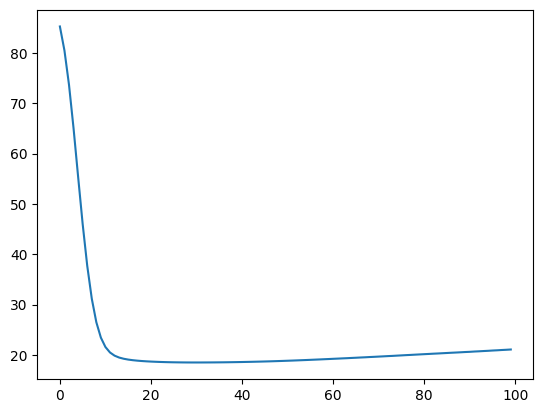

In [67]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [87]:
rookies = pd.read_csv('Data/RookieWR_2023.csv', usecols=['EarlyDeclare', 'FanScore', 'draft_team', 'draft_ovr', 'school', 'ht', 'wt', 'forty', 'vertical', 'player_name'])
rookies.head()

,EarlyDeclare,FanScore,draft_team,draft_ovr,player_name,school,ht,wt,forty,vertical
0,False,17.216667,Detroit Lions,219,Antoine Green,North Carolina,74,199,4.47,33.5
1,False,21.169231,New Orleans Saints,195,A.T. Perry,Wake Forest,76,198,4.47,35.0
2,False,20.395833,Cleveland Browns,74,Cedric Tillman,Tennessee,75,213,4.54,37.0
3,False,24.396154,Cincinnati Bengals,131,Charlie Jones,Purdue,71,175,4.43,36.5
4,False,9.914286,Los Angeles Chargers,125,Derius Davis,TCU,68,165,4.36,36.0


In [88]:
X_sample = rookies.copy()

features_rookies = X_sample[col_names]

features_rookies = scaler.transform(features_rookies.values)

X_sample[col_names] = features_rookies

In [89]:
X_sample["EarlyDeclare"] = enc.transform(X_sample["EarlyDeclare"])
X_sample_enc = pd.get_dummies(X_sample, columns=['school', 'draft_team'])
X_sample_enc = X_sample_enc.reindex(columns = X.columns, fill_value=0)
X_sample_enc.head()

,EarlyDeclare,FanScore,draft_ovr,ht,wt,forty,vertical,school_Ala-Birmingham,school_Alabama,school_Arizona,...,draft_team_Pittsburgh Steelers,draft_team_San Diego Chargers,draft_team_San Francisco 49ers,draft_team_Seattle Seahawks,draft_team_St. Louis Rams,draft_team_Tampa Bay Buccaneers,draft_team_Tennessee Titans,draft_team_Washington Commanders,draft_team_Washington Football Team,draft_team_Washington Redskins
0,0,-0.106098,1.678743,0.630658,-0.199082,-0.025173,-0.820042,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,-0.073897,1.330394,1.498146,-0.264440,-0.025173,-0.299937,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-0.080198,-0.425863,1.064402,0.715933,0.701967,0.393535,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,-0.047608,0.401465,-0.670573,-1.767679,-0.440681,0.220167,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-0.165589,0.314377,-1.971805,-2.421261,-1.167822,0.046799,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
X_sample_enc = torch.tensor(X_sample_enc.values, dtype=torch.float32)

In [91]:
y_pred = model(X_sample_enc)

In [92]:
rookies["PredNFLFanScore"] = pd.DataFrame(y_pred.detach()).astype("float")

In [93]:
rookies.sort_values(by=['PredNFLFanScore'], ascending=False)

,EarlyDeclare,FanScore,draft_team,draft_ovr,player_name,school,ht,wt,forty,vertical,PredNFLFanScore
21,True,14.475000,Los Angeles Chargers,21,Quentin Johnston,TCU,75,208,4.49,40.5,11.356189
9,True,22.288462,Seattle Seahawks,20,Jaxon Smith-Njigba,Ohio St.,73,196,4.52,35.0,11.256920
12,True,24.217857,Minnesota Vikings,23,Jordan Addison,USC,71,173,4.49,34.0,10.679093
16,True,13.538462,Denver Broncos,63,Marvin Mims,Oklahoma,71,183,4.38,39.5,10.465901
11,False,12.030769,Carolina Panthers,39,Jonathan Mingo,Mississippi,74,220,4.46,39.5,9.923150
18,True,27.176923,Houston Texans,69,Nathaniel Dell,Houston,68,165,4.49,36.0,9.545697
22,False,25.595833,Kansas City Chiefs,55,Rashee Rice,SMU,73,204,4.51,41.0,9.066657
10,False,16.934615,Green Bay Packers,50,Jayden Reed,Michigan St.,71,187,4.45,33.5,8.768844
8,True,21.970833,New York Giants,73,Jalin Hyatt,Tennessee,72,176,4.40,40.0,8.736830
13,True,22.450000,Indianapolis Colts,79,Josh Downs,North Carolina,69,171,4.48,38.5,7.805704
